##Wmm lab 5 – Statystyczne właściwości obrazów
Patryk Zdziech \
Nr a 311028

# Informacje wstępne
## Biblioteki:

In [ ]:
import os

import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image, display
from google.colab.patches import cv2_imshow

## Użyty obrazek

311028 % 36 = 24


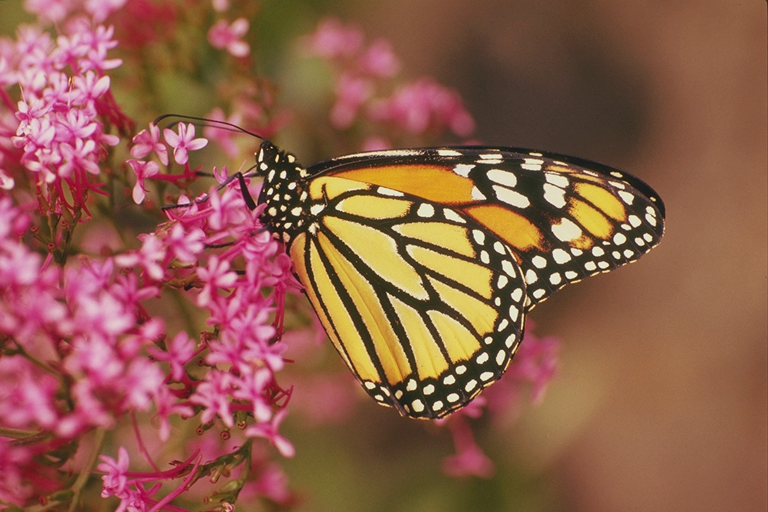

In [ ]:
print(f"311028 % 36 = {311028 % 36}") # monarch_col.png

data_dir = "/content/sample_data/"

image_col = cv2.imread(data_dir+"monarch_col.png", cv2.IMREAD_UNCHANGED)
cv2_imshow(image_col)

# Obraz Monochromatyczny

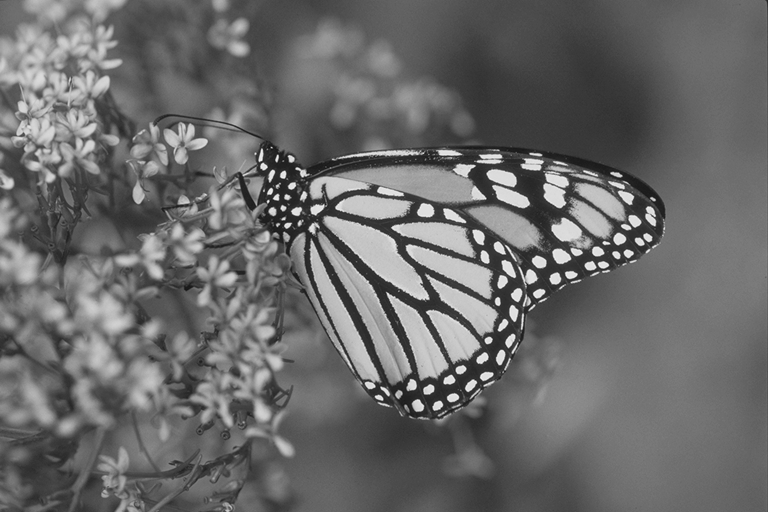

In [ ]:
image_mono = cv2.imread(data_dir+"monarch_mono.png", cv2.IMREAD_UNCHANGED)
cv2_imshow(image_mono)

- Obliczyć  przepływność  (liczbę  bitów  przypadającą  na  jeden  piksel)  dla  obrazu  skompresowanego koderem PNG (obraz wejściowy). 

In [ ]:
def calc_bitrate(image_name):
    """ 
    Obliczenie średniej bitowej dla pliku .png
    os.stat() podaje rozmiar pliku w bajtach, a potrzebny jest w bitach (-> '8*')
    """
    image = cv2.imread(image_name, cv2.IMREAD_UNCHANGED)
    return 8*os.stat(image_name).st_size / (image.shape[0]*image.shape[1])
    
bitrate = calc_bitrate(data_dir+"monarch_mono.png")
print(f"bitrate: {bitrate:.4f}")

bitrate: 4.5279


- Obliczyć entropię obrazu i porównać ją z wyliczoną przepływnością.

In [ ]:
def calc_entropy(hist):
    """ 
    Obliczanie entropii
    """
    if hist.sum() == 0:
          return;
    pdf = hist/hist.sum() ### normalizacja histogramu -> rozkład prawdopodobieństwa
    entropy = -sum([x*np.log2(x) for x in pdf if x != 0])
    return entropy
def make_histogram(image, size):
    hist_image = cv2.calcHist([image], [0], None, [size], [0, size])
    return hist_image.flatten();

hist_mono = make_histogram(image_mono, 256)
mono_entrophy = calc_entropy(hist_mono)
print(f"H(image) = {mono_entrophy:.4f}")


H(image) = 7.1816


Dla kodowania PNG wartości kodowania są zależne więc zależność lśr ≥ H nie jest prawdziwa

## Wyznaczyć obraz różnicowy. 
Dla pierwszego piksela w linii przyjąć wartość sąsiada równą 127.

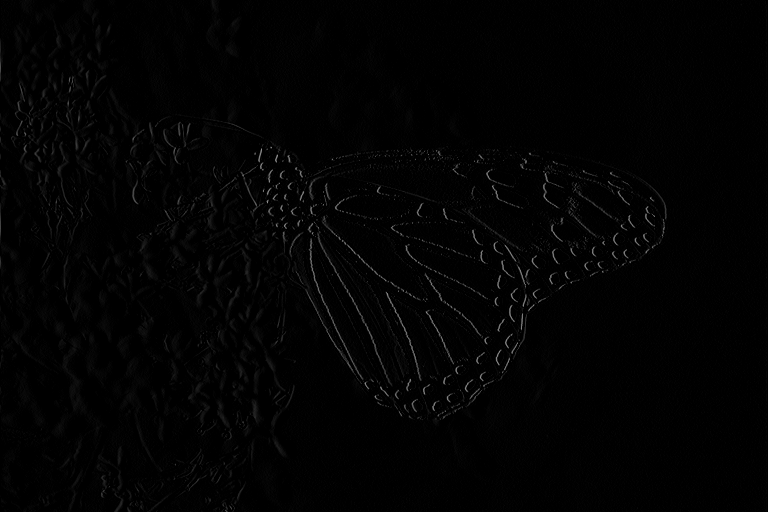

In [ ]:
def differential_image(image):
    img_tmp1 = image[:, 1:]
    img_tmp2 = image[:, :-1]
    """
    W wyniku odejmowania pojawią się wartości ujemne - zakres wartości pikseli w obrazie różnicowym to będzie [-255, 255],
    dlatego trzeba zmienić typ wartości pikseli, żeby zakres wartości nie ograniczał się do [0, 255];
    może to być np. cv2.CV_16S (odpowiednio np.int16 w NumPy), żeby pozostać w domenie liczb całkowitych.
    """
    image_hdiff = cv2.addWeighted(img_tmp1, 1, img_tmp2, -1, 0, dtype=cv2.CV_16S)
    """
    image_hdiff ma o jedną kolumnę mniej - dla skrajnie lewej kolumny nie było danych do odejmowania,
    kolumnę tę można potraktować oddzielnie i 'połączyć' wyniki.
    """
    image_hdiff_0 = cv2.addWeighted(image[:, 0], 1, 0, 0, -127, dtype=cv2.CV_16S)  # od 'zerowej' kolumny obrazu oryginalnego odejmowana stała wartość '127'
    image_hdiff = np.hstack((image_hdiff_0, image_hdiff)) # połączenie tablic
    return image_hdiff

image_hdiff = differential_image(image_mono)
cv2_imshow(image_hdiff)

- Wyznaczyć histogram obrazu różnicowego i porównać go z histogramem obrazu oryginalnego.

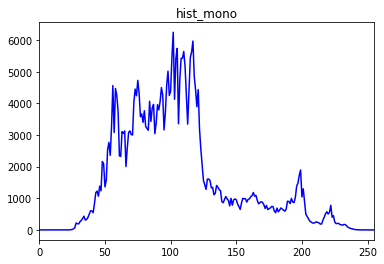

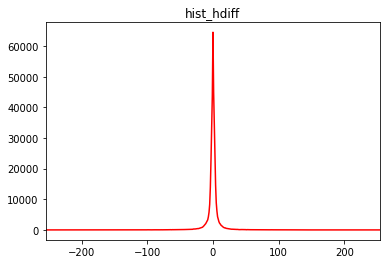

<Figure size 432x288 with 0 Axes>

In [ ]:
image_tmp = (image_hdiff+255).astype(np.uint16)
hist_hdiff = make_histogram(image_tmp, 511)
""" Wyświetlenie histogramów z wykorzystaniem matplotlib.pyplot """
plt.figure()
plt.plot(hist_mono, color="blue")
plt.title("hist_mono")
plt.xlim([0, 255])
plt.figure()
plt.plot(np.arange(-255, 256, 1), hist_hdiff, color="red")# jawne podane wartości 'x' i 'y', żeby zmienić opisy na osi poziomej
plt.title("hist_hdiff")
plt.xlim([-255, 255])
plt.figure()
plt.show()

Histogram obrazu orginalnego ma wartości rozłożone na całym przedziale. Histogram różnicowy ma natomiast większość wartości w okolicach zera. Oznacza to że wartości nie zmieniają się zbyt gwałtownie dla sąsiadujących ze sobą pikseli.

- Wyznaczyć entropię obrazu różnicowego i porównać ją z entropią obrazu oryginalnego.  

In [ ]:
print(f"H(image_mono) = {mono_entrophy:.4f}")
H_hdiff = calc_entropy(hist_hdiff)
print(f"H(hdiff) = {H_hdiff:.4f}")

H(image_mono) = 7.1816
H(hdiff) = 4.4803


Entropia jest mniejsza ponieważ wszystkie wartości pikseli w obrazie różnicowym oscylują wokół zera.

- Wyznaczyć współczynniki DWT korzystając z funkcji zamieszczonej w przykładowym skrypcie.  

LL, wymiary: (256, 384), typ danych: uint8, wartości: 22 - 246


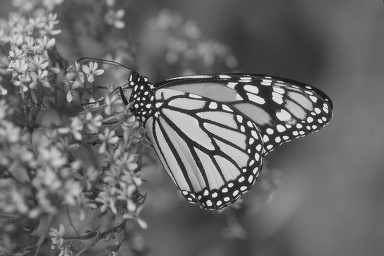

LH, wymiary: (256, 384), typ danych: uint8, wartości: 22 - 246


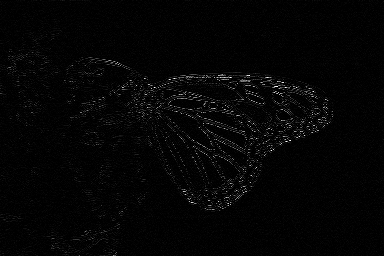

HL, wymiary: (256, 384), typ danych: uint8, wartości: 22 - 246


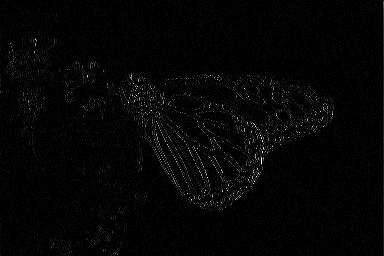

HH, wymiary: (256, 384), typ danych: uint8, wartości: 22 - 246


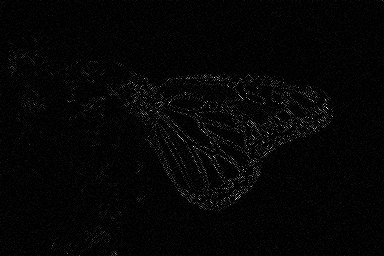

In [ ]:
def printi(img, img_title="image"):
    print(f"{img_title}, wymiary: {img.shape}, typ danych: {img.dtype}, wartości: {img.min()} - {img.max()}")

def dwt(img):
    """
    Bardzo prosta i podstawowa implementacja, nie uwzględniająca efektywnych metod obliczania DWT
    i dopuszczająca pewne niedokładności.
    """
    maskL = np.array([0.02674875741080976, -0.01686411844287795, -0.07822326652898785, 0.2668641184428723,
        0.6029490182363579, 0.2668641184428723, -0.07822326652898785, -0.01686411844287795, 0.02674875741080976])
    maskH = np.array([0.09127176311424948, -0.05754352622849957, -0.5912717631142470, 1.115087052456994,
        -0.5912717631142470, -0.05754352622849957, 0.09127176311424948])

    bandLL = cv2.sepFilter2D(img,         -1, maskL, maskL)[::2, ::2]
    bandLH = cv2.sepFilter2D(img, cv2.CV_16S, maskL, maskH)[::2, ::2] ### ze względu na filtrację górnoprzepustową -> wartości ujemne, dlatego wynik 16-bitowy ze znakiem
    bandHL = cv2.sepFilter2D(img, cv2.CV_16S, maskH, maskL)[::2, ::2]
    bandHH = cv2.sepFilter2D(img, cv2.CV_16S, maskH, maskH)[::2, ::2]

    return bandLL, bandLH, bandHL, bandHH

ll, lh, hl, hh = dwt(image_mono)

printi(ll,"LL")
cv2_imshow(ll)

i = 0
for img in [lh,hl,hh]:
    printi(ll,["LH","HL","HH"][i])
    cv2_imshow(cv2.multiply(img, 3)) ### cv2.multiply() -> zwiększenie kontrastu obrazów 'H', żeby lepiej uwidocznić
    i+=1

- Wyznaczyć histogramy i obliczyć entropię dla wszystkich pasm.

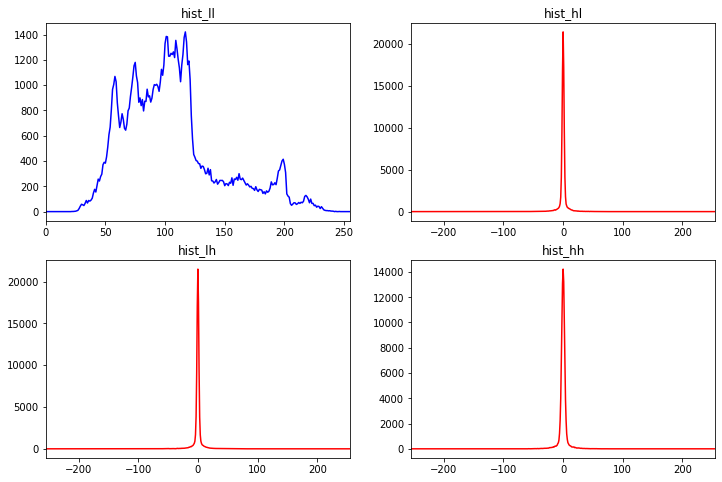

In [ ]:
hist_ll = make_histogram(ll, 256)
hist_lh = make_histogram((lh+255).astype(np.uint16), 511)# zmiana zakresu wartości i typu danych ze względu na cv2.calcHist() (jak wcześniej przy obrazach różnicowych)
hist_hl = make_histogram((hl+255).astype(np.uint16), 511)
hist_hh = make_histogram((hh+255).astype(np.uint16), 511)

""" Wyświetlenie histogramów - jeden obraz z czterema pod-obrazami """
fig = plt.figure()
fig.set_figheight(fig.get_figheight()*2)  # zwiększenie rozmiarów okna
fig.set_figwidth(fig.get_figwidth()*2)
plt.subplot(2, 2, 1)
plt.plot(hist_ll, color="blue")
plt.title("hist_ll")
plt.xlim([0, 255])
plt.subplot(2, 2, 3)
plt.plot(np.arange(-255, 256, 1), hist_lh, color="red")
plt.title("hist_lh")
plt.xlim([-255, 255])
plt.subplot(2, 2, 2)
plt.plot(np.arange(-255, 256, 1), hist_hl, color="red")
plt.title("hist_hl")
plt.xlim([-255, 255])
plt.subplot(2, 2, 4)
plt.plot(np.arange(-255, 256, 1), hist_hh, color="red")
plt.title("hist_hh")
plt.xlim([-255, 255])

plt.show()  # wyświetlenie okien i oczekiwanie na ich zamnkięcie

In [ ]:
H_ll = calc_entropy(hist_ll)
H_lh = calc_entropy(hist_lh)
H_hl = calc_entropy(hist_hl)
H_hh = calc_entropy(hist_hh)

print(f"H(LL) = {H_ll:.4f} \nH(LH) = {H_lh:.4f} \nH(HL) = {H_hl:.4f} \nH(HH) = {H_hh:.4f} \nH_śr = {(H_ll + H_lh + H_hl + H_hh)/4:.4f}\n")

print(f"H(image_mono) = {mono_entrophy:.4f}")
H_hdiff = calc_entropy(hist_hdiff)
print(f"H(hdiff) = {H_hdiff:.4f}")

H(LL) = 7.1636 
H(LH) = 3.6994 
H(HL) = 3.6809 
H(HH) = 4.0224 
H_śr = 4.6416

H(image_mono) = 7.1816
H(hdiff) = 4.4803


Pasmo LL wyróżnia się ponieważ jest najbardziej zbliżone do obrazu orginalnego. Zachowane jest rozłożenie wartości na całej skali jak i również poziom entropii pozostaje podobny. Pasma LH, HL, HH niosą natomiast mniej informacji i są podobne bardziej do obrazu różnicowego pod względem entropi i wyglądu histogramu (wartości skupione w okolicach zera).

# Obraz Barwny

- Obliczyć entropię dla składowych RGB barwnego obrazu testowego.  

H(R) = 7.4042 
H(G) = 7.0843 
H(B) = 6.9801 
H_śr = 7.1562


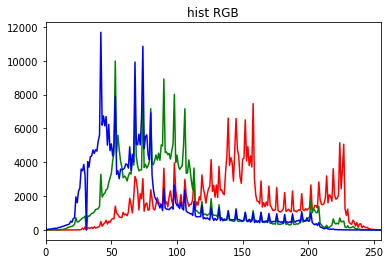

In [ ]:
image_col = cv2.imread(data_dir+"monarch_col.png")

image_R = image_col[:, :, 2]  # cv2.imread() zwraca obrazy w formacie BGR
image_G = image_col[:, :, 1]
image_B = image_col[:, :, 0]

hist_R = make_histogram(image_R, 256)
hist_G = make_histogram(image_G, 256)
hist_B = make_histogram(image_B, 256)

H_R = calc_entropy(hist_R)
H_G = calc_entropy(hist_G)
H_B = calc_entropy(hist_B)
print(f"H(R) = {H_R:.4f} \nH(G) = {H_G:.4f} \nH(B) = {H_B:.4f} \nH_śr = {(H_R+H_G+H_B)/3:.4f}")

plt.figure()
plt.plot(hist_R, color="red")
plt.plot(hist_G, color="green")
plt.plot(hist_B, color="blue")
plt.title("hist RGB")
plt.xlim([0, 255])
plt.show()

- Dokonać konwersji z RGB do YUV i obliczyć entropię dla składowych YUV. Wyznaczyć histogramy dla wszystkich składowych.

image_YUV, wymiary: (512, 768, 3), typ danych: uint8, wartości: 17 - 245
H(Y) = 7.1842 
H(U) = 5.3158 
H(V) = 5.8143 
H_śr = 6.1047


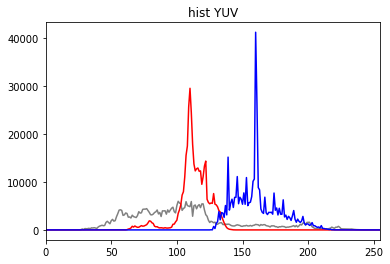

In [ ]:
image_YUV = cv2.cvtColor(image_col, cv2.COLOR_BGR2YUV)
printi(image_YUV, "image_YUV")

image_Y = image_YUV[:, :, 0]
image_U = image_YUV[:, :, 1]
image_V = image_YUV[:, :, 2]

hist_Y = make_histogram(image_Y, 256)
hist_U = make_histogram(image_U, 256)
hist_V = make_histogram(image_V, 256)

H_Y = calc_entropy(hist_Y)
H_U = calc_entropy(hist_U)
H_V = calc_entropy(hist_V)
print(f"H(Y) = {H_Y:.4f} \nH(U) = {H_U:.4f} \nH(V) = {H_V:.4f} \nH_śr = {(H_Y+H_U+H_V)/3:.4f}")

plt.figure()
plt.plot(hist_Y, color="gray")
plt.plot(hist_U, color="red")
plt.plot(hist_V, color="blue")
plt.title("hist YUV")
plt.xlim([0, 255])
plt.show()              ### wyświetlenie okien i oczekiwanie na ich zamnkięcie


Dla składowych UV entropia jest mniejsza, ponieważ są one ograniczone do węższych zakresów niż składowe na histogramie RGB. Na histogramie RGB wszystkie składowe rozkładają się na całym zakresie



- Wyznaczyć zależność zniekształcenia D od przepływności R – tzw. krzywa R-D – dla kodera JPEG.  
Regulacji stopnia kompresji (przepływności R) należy dokonywać ustawiając wartości parametru `quality` przy zapisie obrazu do pliku. Wartości parametru `quality` należy dobrać tak, aby uzyskać `gładkie` wykresy.

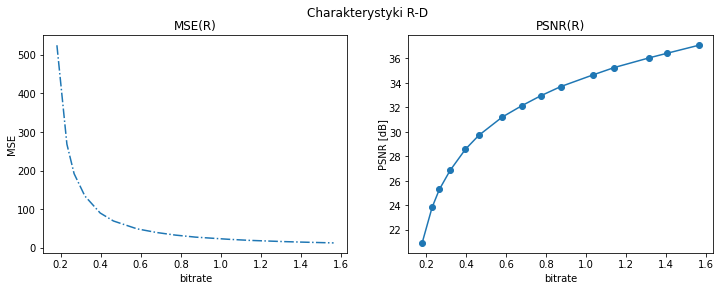

In [ ]:
def calc_mse_psnr(img1, img2):
    """ Funkcja obliczająca MSE i PSNR dla różnicy podanych obrazów, zakładana wartość pikseli z przedziału [0, 255]. """
    imax = 255.**2  # maksymalna wartość sygnału -> 255
    """
    W różnicy obrazów istotne są wartości ujemne, dlatego img1 konwertowany jest do typu np.float64 (liczby rzeczywiste)
    aby nie ograniczać wyniku do przedziału [0, 255].
    """
    mse = ((img1.astype(np.float64)-img2)**2).sum() / \
        img1.size  # img1.size - liczba elementów w img1, ==img1.shape[0]*img1.shape[1] dla obrazów mono, ==img1.shape[0]*img1.shape[1]*img1.shape[2] dla obrazów barwnych
    psnr = 10.0*np.log10(imax/mse)
    return (mse, psnr)


xx = []  # tablica na wartości osi X -> bitrate
ym = []  # tablica na wartości osi Y dla MSE
yp = []  # tablica na wartości osi Y dla PSNR

for quality in [2, 5, 7 ,10,15,*[i for i in range(20,80,10)],75,80,82,85]:
    out_file_name = f"{data_dir}out_image_q{quality:03d}.jpg"
    """ Zapis do pliku w formacie .jpg z ustaloną 'jakością' """
    cv2.imwrite(out_file_name, image_col, (cv2.IMWRITE_JPEG_QUALITY, quality))
    """ Odczyt skompresowanego obrazu, policzenie bitrate'u i PSNR """
    image_compressed = cv2.imread(out_file_name, cv2.IMREAD_UNCHANGED)# image_col.shape == image_compressed.shape
    bitrate = 8*os.stat(out_file_name).st_size/(image_col.shape[0]*image_col.shape[1])
    mse, psnr = calc_mse_psnr(image_col, image_compressed)
    """ Zapamiętanie wyników do pózniejszego wykorzystania """
    xx.append(bitrate)
    ym.append(mse)
    yp.append(psnr)
cv2.imwrite(data_dir+"out_image_q100.jpg", image_col, (cv2.IMWRITE_JPEG_QUALITY,100))

""" Narysowanie wykresów """
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth()*2)
plt.suptitle("Charakterystyki R-D")
plt.subplot(1, 2, 1)
plt.plot(xx, ym, "-.")
plt.title("MSE(R)")
plt.xlabel("bitrate")
plt.ylabel("MSE", labelpad=0)
plt.subplot(1, 2, 2)
plt.plot(xx, yp, "-o")
plt.title("PSNR(R)")
plt.xlabel("bitrate")
plt.ylabel("PSNR [dB]", labelpad=0)
plt.show()

- Dokonać subiektywnej oceny obrazów zrekonstruowanych.

Image quality: 75


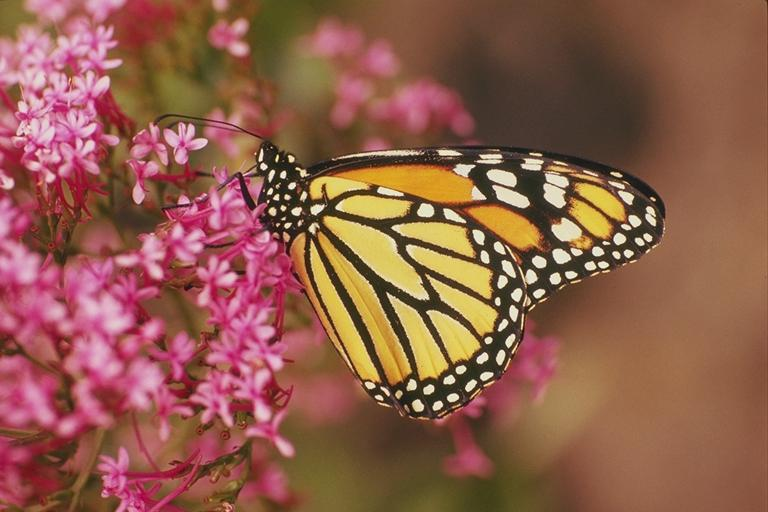

Jakość: Bardzo dobra - Zniekształcenia niewidoczne

Image quality: 40


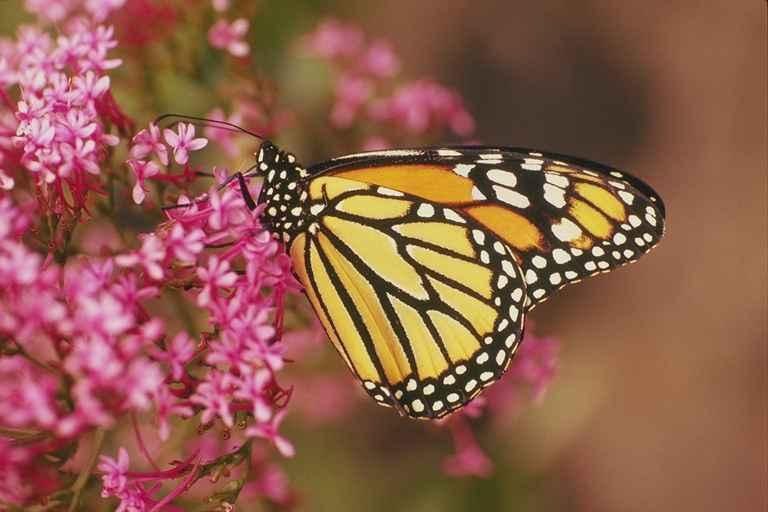

Jakość: Dobra - Można zauważyć zniekształcenia w tle

Image quality: 20


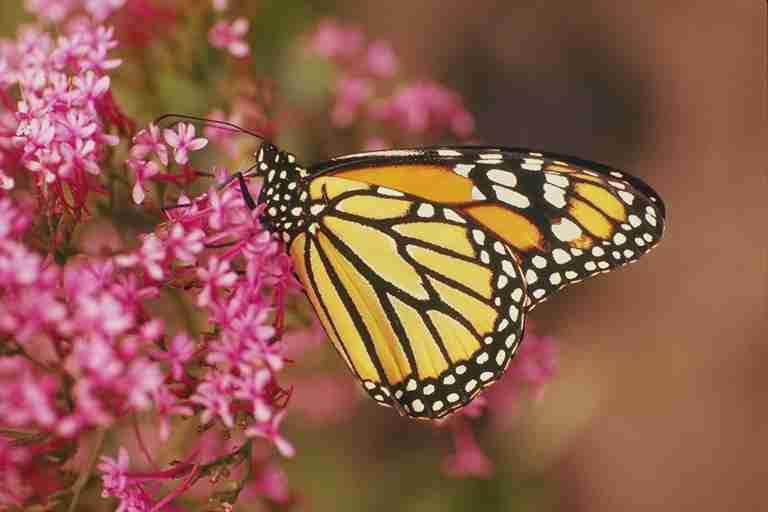

Jakość: Średnia - zniekształcenia w tle można szybko zauważyć

Image quality: 10


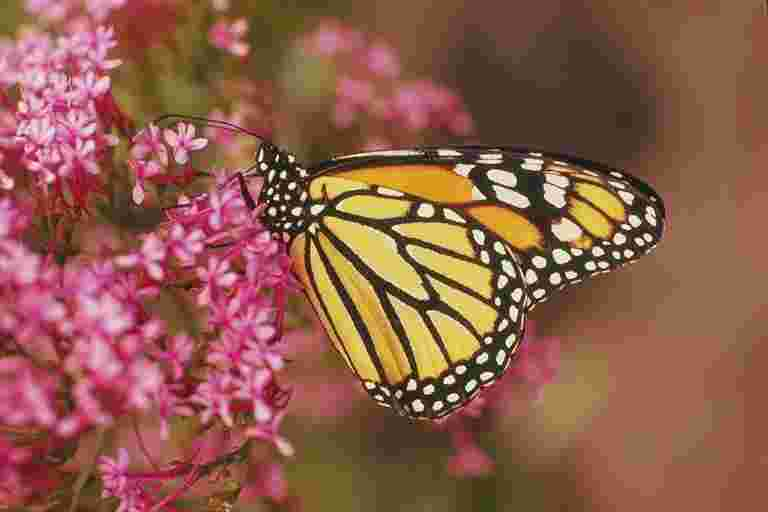

Jakość: Kiepska - cały obrazek ma widoczne zniekształcenia

Image quality: 7


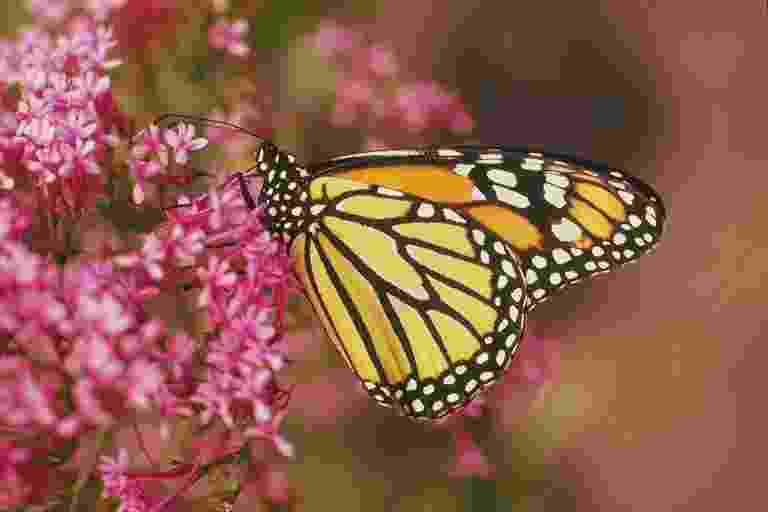

Jakość: Zła - na obrazku zaczynają pojawiać się dziwne plamy kolorów

Image quality: 5


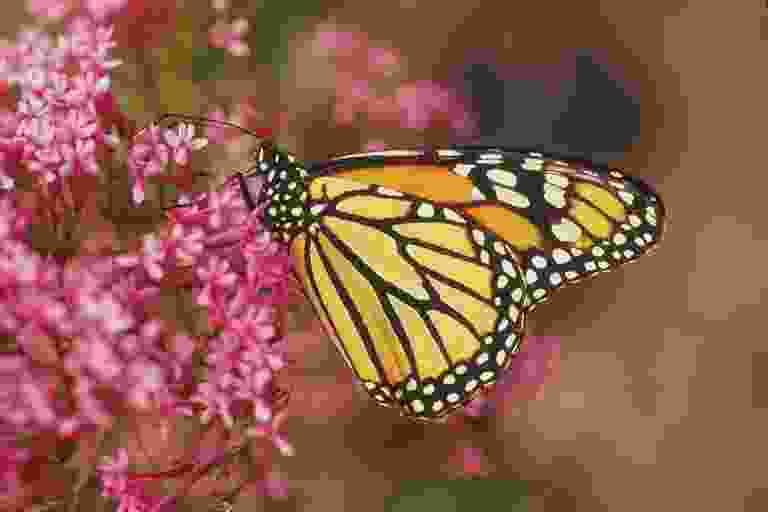

Jakość: Bardzo zła



In [ ]:
i = 0
for quality in [75,40,20,10,7,5]:#wybrane wartosci przy ktorych zachodzi zmiana
    out_file_name = f"{data_dir}out_image_q{quality:03d}.jpg"
    """ Odczyt skompresowanego obrazu, policzenie bitrate'u i PSNR """
    image_compressed = cv2.imread(out_file_name, cv2.IMREAD_UNCHANGED)
    print(f"Image quality: {quality}")
    cv2_imshow(image_compressed)
    print("Jakość: " + (["Bardzo dobra - Zniekształcenia niewidoczne","Dobra - Można zauważyć zniekształcenia w tle","Średnia - zniekształcenia w tle można szybko zauważyć","Kiepska - cały obrazek ma widoczne zniekształcenia","Zła - na obrazku zaczynają pojawiać się dziwne plamy kolorów","Bardzo zła"][i]) +"\n")
    i+=1

- Porównać stopnie kompresji uzyskiwane dla kodera JPEG ze stopniem kompresji uzyskanym dla kodera PNG. (ewentualnie wyliczyć przepływność bitową dla obrazu barwnego skompresowanego koderem PNG).

In [ ]:
png_bitrate = calc_bitrate(data_dir+"monarch_col.png")
png_size = os.stat(data_dir+"monarch_col.png").st_size / 1024
jpeg_1_size = os.stat(data_dir+"out_image_q100.jpg").st_size / 1024
jpeg_2_size = os.stat(data_dir+"out_image_q075.jpg").st_size / 1024
print(f"Przepływność bitowa dla obrazu barwnego skompresowanego PNG: {png_bitrate}\n")
print(f"Rozmiar obrazu PNG: {png_size} KB\n")
print(f"Rozmiar obrazu JPEG dla jakości = 100%: {jpeg_1_size} KB\n")
print(f"Rozmiar obrazu JPEG dla jakości \"bardzo dobrej\": {jpeg_2_size} KB\n")

Przepływność bitowa dla obrazu barwnego skompresowanego PNG: 12.536966959635416

Rozmiar obrazu PNG: 601.7744140625 KB

Rozmiar obrazu JPEG dla jakości = 100%: 298.654296875 KB

Rozmiar obrazu JPEG dla jakości "bardzo dobrej": 54.767578125 KB



Jak widać koder JPEG kompresuje plik o wiele lepiej od kodera PNG. Plik JPEG potrafi być kilka albo nawet kilkanaście razy mniejszy od pliku PNG zależnie od wybranej jakości.